# Data exploration

Sofia Zorrilla Azcué

## Sampling map

[Gorman et al., 2014](https://doi.org/10.1371/journal.pone.0090081) -
Publicaron un artículo con datos de medidas morfológicas de 3 especies
de pingüinos.

| ***Pygoscelis** adeliae* | *Pygoscelis gentoo* | ***Pygoscelis antarcticus*** |
|------------------------|------------------------|------------------------|
| ![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Hope_Bay-2016-Trinity_Peninsula%E2%80%93Ad%C3%A9lie_penguin_%28Pygoscelis_adeliae%29_04.jpg/1200px-Hope_Bay-2016-Trinity_Peninsula%E2%80%93Ad%C3%A9lie_penguin_%28Pygoscelis_adeliae%29_04.jpg) | ![](https://upload.wikimedia.org/wikipedia/commons/b/be/Pygoscelis_papua.jpg) | ![](https://upload.wikimedia.org/wikipedia/commons/4/44/Manchot_04.jpg){ width="197"} |

Las muestras fueron colectadas en 3 sitios diferentes

In [ ]:
#| message: false
#| warning: false
#| include: false
#| echo: false

library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'rnaturalearthdata'

The following object is masked from 'package:rnaturalearth':

    countries110

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

ℹ Please use the `linewidth` argument instead.

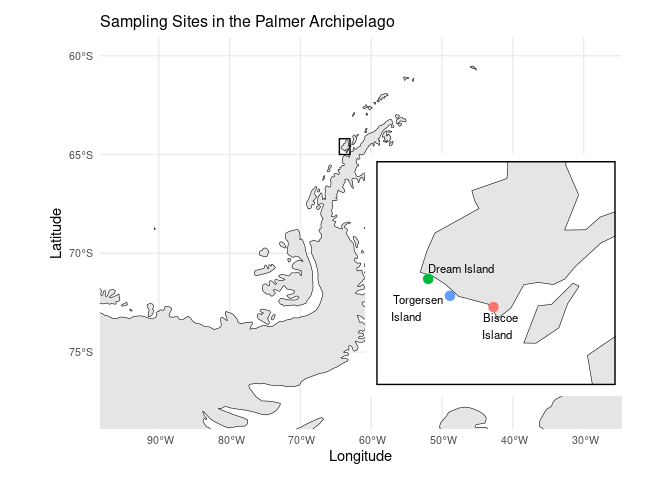

In [ ]:
#| label: mapa-distribucion
#| warning: false

data("penguins")

# Coordenadas obtenidas a partir del artículo original (https://doi.org/10.1371/journal.pone.0090081)
coordinates <- data.frame(
  Island = c("Biscoe\nIsland", "Torgersen\nIsland", "Dream Island"),
  Latitude = c(-64.800, -64.767, -64.717),
  Longitude = c(-63.767, -64.067, -64.217)
)


# Get Antarctica and nearby islands data
antarctica <- ne_countries(scale = "medium", continent = "antarctica", returnclass = "sf")

# Main map (Antarctica)
main_map <- ggplot(data = antarctica) +
  geom_sf(fill = "gray90", color = "black") +
  theme_minimal() +
  geom_rect(
    xmin = -64.5, xmax = -63, ymin = -65, ymax = -64.2,
    color = "black", fill = NA, linewidth = 0.5
  ) +
  labs(title = "Sampling Sites in the Palmer Archipelago", x = "Longitude", y = "Latitude") +
  coord_sf(xlim = c(-95, -28), ylim = c(-78, -60)) +
  theme(
    axis.text = element_text(size = 8),
    plot.title = element_text(size = 12)
  )

# Inset map (Palmer Archipelago region)
inset_map <- ggplot(data = antarctica) +
  geom_sf(fill = "gray90", color = "black") +
  geom_point(data = coordinates, aes(x = Longitude, y = Latitude, color = Island), size = 3) +
  geom_text_repel(data = coordinates, aes(x = Longitude, y = Latitude, label = Island), 
            hjust = -0.1, vjust = 0.5, size = 3) +
  theme_bw()+
  theme(legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(), 
        axis.title = element_blank(),
        panel.border = element_rect(color = 'black', size = 1),
        panel.grid = element_blank()) +
  coord_sf(xlim = c(-64.5, -63), ylim = c(-65, -64.4)) +
  labs(x = "Longitude", y = "Latitude")

## Tamaño de muestreo

In [ ]:
#| label: tbl-sampling
#|
# Sampling size
levels(penguins$sex) <- c("female", "male","Unkn.")
levels(penguins$species) <- c("P. adelie", "P. chinstrap", "P. gentoo")
penguins$sex[is.na(penguins$sex)] <- "Unkn."

penguins %>% 
  # Summarize data by species, island, and sex
  summarise(n = n(), .by = c(species, island, sex)) %>% 
  
  # Convert count to character to allow empty string
  mutate(n = as.character(n)) %>% 
  
  # Reshape data to wide format
  pivot_wider(
    id_cols = c(species, island), 
    names_from = sex, 
    values_from = n, 
    values_fill = list(n = "")
  ) %>% 
  
  # Create gt table, grouping by species
  gt(groupname_col = "species") %>% 
  
  # Customize column labels
  cols_label(
    island = "Species/Island", 
    male = "Male", 
    female = "Female"
  ) %>% 
  
  # Bold column labels
  tab_style(
    style = cell_text(weight = "bold"), 
    locations = cells_column_labels()
  ) %>% 
  
  # Italicize row group labels (species)
  tab_style(
    style = cell_text(style = "italic"),
    locations = cells_row_groups()
  )

## Visualización de variables por sexo

Warning in check_and_set_ggpairs_defaults("diag", diag, continuous =
"densityDiag", : Changing diag$continuous from 'blank' to 'blankDiag'

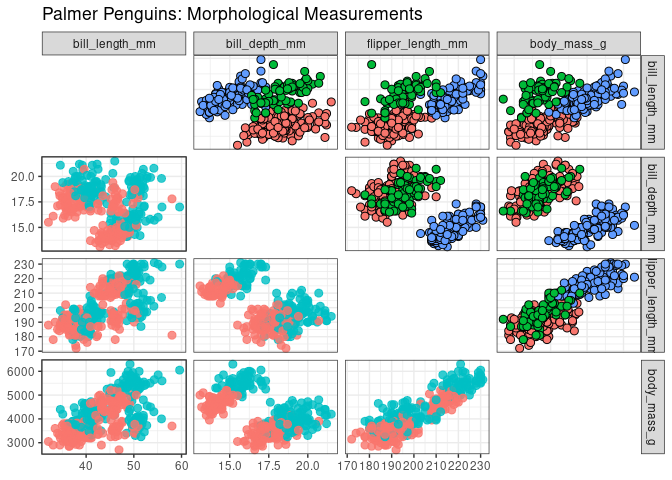

In [ ]:
#| message: false
#| warning: false
#| output: false
#| label: fig-exploration
#| fig-cap: 'Visualización de la distribución de medidas por sexo (triangulo inferior de la matriz; azul = machos, rojo = hembras) y especie (triangulo superior de la matriz: *P. adelie*: rojo, *P. chinstrap*: verde, *P. gentoo*: azul)'

data(penguins)

penguins%>%
  filter(!is.na(sex)) %>%
  select(-c(island, year)) %>%
  ggpairs(
    columns = 2:5,
    mapping = aes(color = sex, fill = species), 
    upper = list(continuous = wrap("points", shape = 21, size = 2.5, mapping = aes( fill = sex), color = "black")),  
    diag = list(continuous = "blank"), 
    lower = list(continuous = wrap("points", size = 2.5, alpha = 0.8)) 
  ) +
  theme_bw() +
  labs(title = "Palmer Penguins: Morphological Measurements") +
  theme(legend.position = "bottom")